# Dataset

https://www.kaggle.com/datasets/parv619/hackerearth-how-not-to-lose-a-customer-in-10-days

In [1]:
!gdown --fuzzy https://drive.google.com/file/d/158xNk685wA8RfgVhcEdhteD0lJ49SObV/view?usp=sharing -O churn.zip
!unzip churn.zip

Downloading...
From: https://drive.google.com/uc?id=158xNk685wA8RfgVhcEdhteD0lJ49SObV
To: /content/churn.zip
100% 3.59M/3.59M [00:00<00:00, 87.1MB/s]
Archive:  churn.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
import pandas as pd

train = pd.read_csv('train.csv',parse_dates=['joining_date','last_visit_time'])

In [3]:
train['joining_date'] = train['joining_date'].apply(lambda x: x.timestamp()).astype(int)
train['last_visit_time'] = train['last_visit_time'].dt.hour
train['avg_frequency_login_days'] = train['avg_frequency_login_days'].replace('Error','9999.0').astype(float)
train = train.drop(['customer_id','Name','security_no','referral_id'],axis=1)

In [4]:
codes = {}
for c in train.columns:
  if train[c].dtype == 'object':
    train[c], codigo = pd.factorize(train[c], sort=True)
    codes[c] = codigo.values

In [5]:
train['points_in_wallet'] = train['points_in_wallet'].fillna(0)

## Análise de Dados

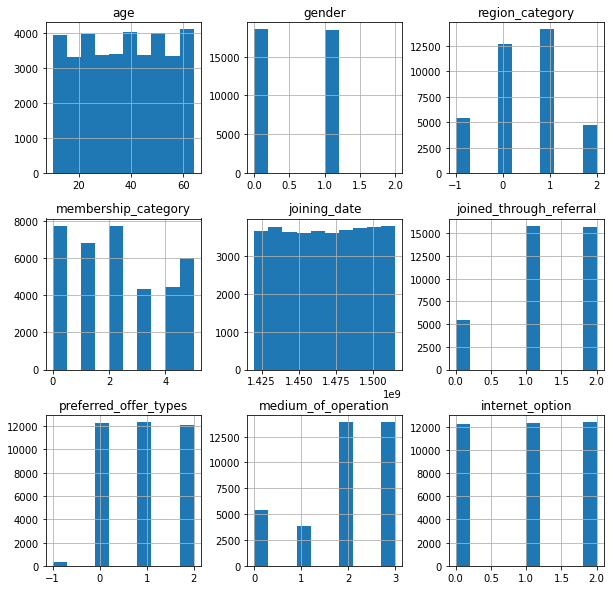

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
_=train[train.columns[:9]].hist()

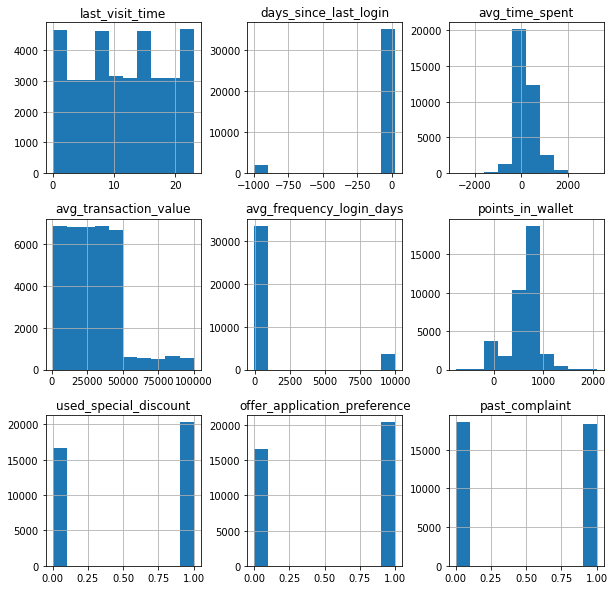

In [7]:
_=train[train.columns[9:18]].hist()

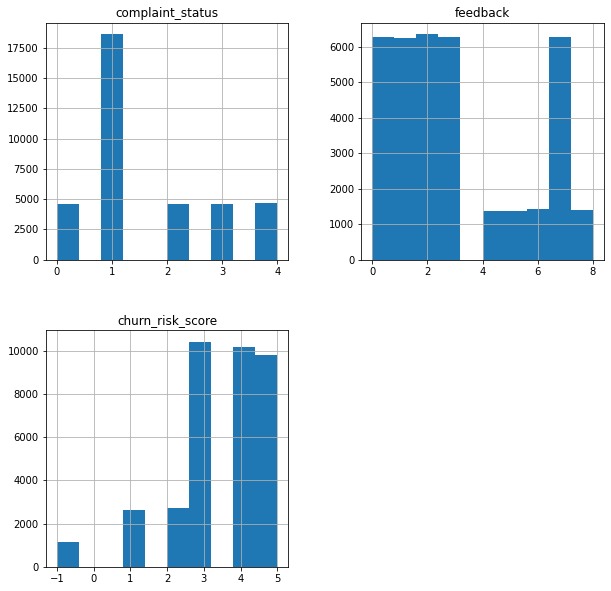

In [8]:
_=train[train.columns[18:]].hist()

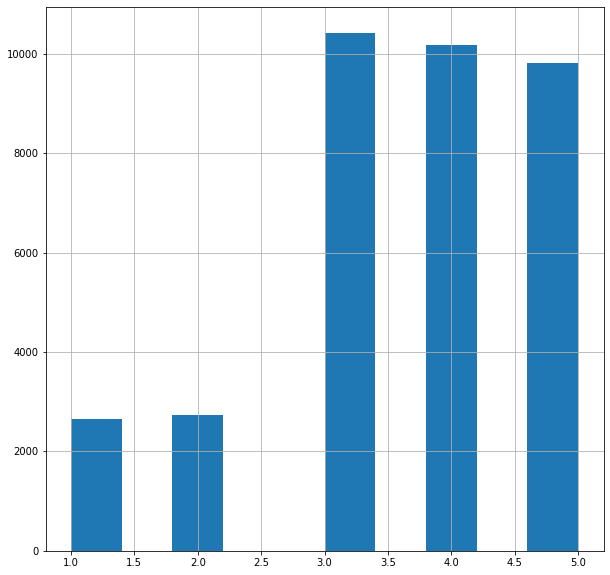

In [9]:
# removendo risco < 0
train = train[train[train.columns[-1]]>=0]
_ = train[train.columns[-1]].hist()

# Configurações iniciais

In [10]:
X = train[train.columns[:-1]].values
y = train[train.columns[-1]].values

In [11]:
import warnings

## Classificação - Técnicas

In [19]:
# Import dos classificadores
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

tecnicas_decomp = [
  PassiveAggressiveClassifier(random_state=42),
  RidgeClassifier(random_state=42),
  DecisionTreeClassifier(max_depth=10,random_state=42),
  ExtraTreeClassifier(max_depth=10,random_state=42),
  KNeighborsClassifier(),
  RadiusNeighborsClassifier(),
  RandomForestClassifier(max_depth=10,random_state=42),
  AdaBoostClassifier(random_state=42),
  BaggingClassifier(random_state=42),
  HistGradientBoostingClassifier(max_depth=8,random_state=42),
  ExtraTreesClassifier(max_depth=8,random_state=42),
]

## Regressão - Técnicas

In [13]:
# Import dos regressores
from sklearn.linear_model import PassiveAggressiveRegressor, SGDRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor, 
                              BaggingRegressor, HistGradientBoostingRegressor, 
                              GradientBoostingRegressor, ExtraTreesRegressor)
from sklearn.neural_network import MLPRegressor

#Técnicas usadas
tecnicas_regress = [
  PassiveAggressiveRegressor(random_state=42),
  SGDRegressor(random_state=42),
  LinearRegression(),
  DecisionTreeRegressor(max_depth=10,random_state=42),
  ExtraTreeRegressor(max_depth=10,random_state=42),
  KNeighborsRegressor(),
  RadiusNeighborsRegressor(),
  RandomForestRegressor(max_depth=10,random_state=42),
  AdaBoostRegressor(random_state=42),
  BaggingRegressor(random_state=42),
  HistGradientBoostingRegressor(max_depth=8,random_state=42),
  GradientBoostingRegressor(random_state=42),
  ExtraTreesRegressor(max_depth=8,random_state=42),
  MLPRegressor(random_state=42),
]

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score

## Pré processamento - Técnicas e métricas

In [14]:
# Import da bibliotecas usadas para performance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix

### Pré Processadores

In [15]:
# Import dos pre processadores
from sklearn.preprocessing import Normalizer, MinMaxScaler, RobustScaler

prepros = [
    None,
    Normalizer(),
    MinMaxScaler(),
    RobustScaler(),
]

### Decompositores

In [16]:
# Import dos decompositores
from sklearn.decomposition import PCA, FactorAnalysis, FastICA, TruncatedSVD

decompositores = [
    None,
    PCA(n_components=3,random_state=42),
    FactorAnalysis(n_components=3,random_state=42),
    FastICA(n_components=3,random_state=42),
    TruncatedSVD(n_components=3,random_state=42),
]

# Experimentação

## Classificadores - Com pré processamento

In [ ]:
%%time
res = []
warnings.filterwarnings('ignore')

metricas = ['balanced_accuracy','precision_macro','recall_macro','f1_macro']

for pp in prepros:
    nomePP = pp.__class__.__name__

    if pp != None: Xp = pp.fit_transform(X)
    else: Xp = X

    for dc in decompositores:
        nomeDC = dc.__class__.__name__

        if dc != None: Xd = dc.fit_transform(Xp)
        else: Xd = Xp

        for tec in tecnicas_decomp:
          nomeAM = tec.__class__.__name__,
          grid = GridSearchCV(tec,{},scoring=metricas,n_jobs=-1,refit=False,cv=5)
          grid.fit(Xd,y)
          dn = {
            'pre-p':nomePP,
            'decompositor':nomeDC,
            'aprendizado':nomeAM,
            'tempo':grid.cv_results_['mean_fit_time'][0],
            }
          for mt in metricas:
            dn[mt] = grid.cv_results_[f'mean_test_{mt}'][0]

          res.append(dn)

warnings.filterwarnings('default')

resultados = pd.DataFrame(data=res)
resultados = resultados.sort_values(by=resultados.columns[-1],ascending=False)

## Regressores - Com pré processamento

In [ ]:
rr = []
metricas = [
    'neg_mean_absolute_error',
    'neg_mean_squared_error',
    'r2',
    'neg_median_absolute_error', 
    'neg_mean_absolute_percentage_error'
]
for pp in prepros:
    nomePP = pp.__class__.__name__

    if pp != None: Xp = pp.fit_transform(X)
    else: Xp = X

    for dc in decompositores:
        nomeDC = dc.__class__.__name__

        if dc != None: Xd = dc.fit_transform(Xp)
        else: Xd = Xp

        for tec in tecnicas_regress:
            grid = GridSearchCV(tec,{},scoring=metricas,n_jobs=-1,refit=False,cv=5)
            grid.fit(X,y)
            dn = {
              'pre-p':nomePP,
              'decompositor':nomeDC,
              'aprendizado':tec.__class__.__name__,
              'tempo':grid.cv_results_['mean_fit_time'][0],
            }
            for mt in metricas:
              dn[mt] = grid.cv_results_[f'mean_test_{mt}'][0]

            rr.append(dn)

warnings.filterwarnings('default')

resultados = pd.DataFrame(data=rr)
resultados = resultados.sort_values(by=resultados.columns[-1],ascending=False)
resultados.to_csv('pre_decomp_regressores.csv')

!cp pre_decomp_regressores.csv "drive/My Drive/"

In [23]:
from google.colab import drive
drive.mount('drive')

Mounted at drive
